In [2]:
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", ticks=True, grid=False)

import os
import imp
import sys
import h5py
import yaml
import numpy as np
from numba import njit

import fastpli.simulation
import fastpli.analysis
import fastpli.tools
import fastpli.io
imp.reload(fastpli)

import matplotlib.pyplot as plt
import tikzplotlib

import vector_field_generation as vfg
imp.reload(vfg)

np.random.seed(42)

FILE_PATH = os.path.abspath('')
print(FILE_PATH)
print(fastpli.__version__)

NUM_PROC = 16
with open(os.path.join(FILE_PATH, '.numba_config.yaml'), 'w') as file:
    yaml.dump({'num_threads': NUM_PROC}, file)
print(f'NUM_PROC: {NUM_PROC}')

/data/PLI-Group/felix/data/thesis/1_tests
fastpli: v0.9.8-7-ge5aa339
Branch: development
Hash: e5aa339
Build: Release
NUM_PROC: 16


In [17]:
simpli = fastpli.simulation.Simpli()

# optical_axis_high = np.random.uniform(-1,1,(3,3,3,3)).astype(np.float32)
# vf_intp = np.random.uniform(-1,1,(3,3,3,3)).astype(np.float32)

# vf_diff = np.empty(optical_axis_high.shape[:-1], dtype = np.float32)
# simpli._Simpli__sim.__diff_angle(optical_axis_high, vf_intp, vf_diff)
# vf_diff_ = vfg.VectorOrientationDiffAngle(optical_axis_high, vf_intp)

print(np.amax(vf_diff.ravel() - vf_diff_.ravel()))

0.00048828125


/data/PLI-Group/felix/data/thesis/1_tests
low res: 10, mode: NN -> 19 MB
scale: 10, mode: NN -> 19073 MB
IntpVecField: NN
diff
3000000000, 3000000000, 1000000000
diff done
sort done
/data/PLI-Group/felix/data/thesis/1_tests
IntpVecField: Lerp
diff
3000000000, 3000000000, 1000000000
diff done
sort done
/data/PLI-Group/felix/data/thesis/1_tests
IntpVecField: Slerp
diff
3000000000, 3000000000, 1000000000
diff done
sort done


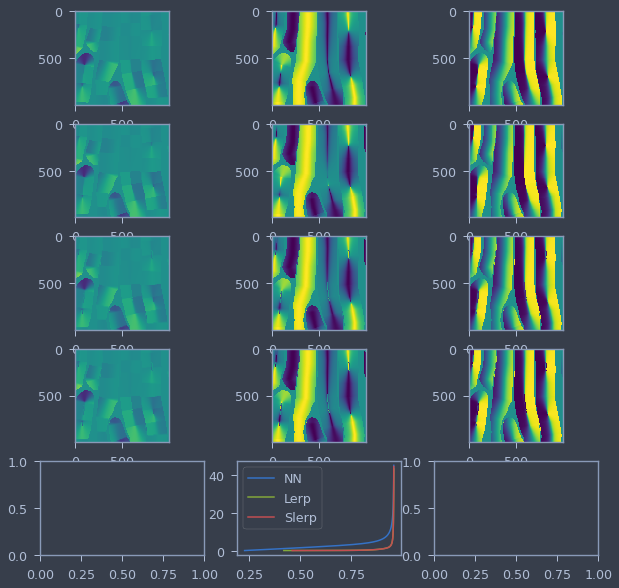

In [37]:
voxel_size = 0.1
scale = 10

fig, axs = plt.subplots(5, 3,figsize=(10, 10))
for m, mode in enumerate(["NN", "Lerp", "Slerp"]):
    
    simpli = fastpli.simulation.Simpli()
    simpli.omp_num_threads = NUM_PROC
    print(FILE_PATH)
    simpli.fiber_bundles = fastpli.io.fiber_bundles.load(
        os.path.join(FILE_PATH, '..', 'data', 'models', '1_rnd_seed',
                     'cube_2pop_psi_1.00_omega_0.00_r_1.00_v0_210_.solved.h5'))

    simpli.voxel_size = voxel_size  # in µm meter
    simpli.set_voi([-5] * 3, [5] * 3)  # in µm meter
#     simpli.set_voi([-10] * 3, [10] * 3)  # in µm meter
    voxel_size_0 = simpli.voxel_size
    
    simpli.fiber_bundles_properties = [[(1.0, 0.002, 0, 'r')]
                                       ] * len(simpli.fiber_bundles)
    if m == 0:
        # low resolution
        simpli.voxel_size = voxel_size_0  # in µm meter
        print(
            f"low res: {scale}, mode: {mode} -> {simpli.memory_usage('MB'):.0f} MB"
        )

        tissue, optical_axis, tissue_properties = simpli.generate_tissue()
        
        # high resolution
        simpli.voxel_size = voxel_size_0 / scale  # in µm meter
        print(
            f"scale: {scale}, mode: {mode} -> {simpli.memory_usage('MB'):.0f} MB"
        )
        if simpli.memory_usage('MB') > 128 * 1e3:
            print("MEMORY!")
            sys.exit(1)
        tissue_high, optical_axis_high, tissue_properties = simpli.generate_tissue(
        )
        
#         mask = optical_axis_high[:,:,:,0] < 0
#         optical_axis_high[mask,:] *= -1
        axs[m, 0].imshow(optical_axis_high[:, tissue_high.shape[1] // 2, :,0],
                     vmin=-1,
                     vmax=1, interpolation='none')
        axs[m, 1].imshow(optical_axis_high[:, tissue_high.shape[1] // 2, :,1],
                         vmin=-1,
                         vmax=1, interpolation='none')
        axs[m, 2].imshow(optical_axis_high[:, tissue_high.shape[1] // 2, :,2],
                         vmin=-1,
                         vmax=1, interpolation='none')
        
    print(f"IntpVecField: {mode}")
    tissue_int = np.empty_like(tissue_high)
    vf_intp = np.empty_like(optical_axis_high)

    simpli._Simpli__sim.__field_interpolation(tissue.shape, tissue_int.shape,
                                              tissue, optical_axis, tissue_int,
                                              vf_intp, mode)
    
#     mask = vf_intp[:,:,:,0] < 0
#     vf_intp[mask,:] *= -1

    axs[m+1, 0].imshow(vf_intp[:, tissue_high.shape[1] // 2, :,0],
                     vmin=-1,
                     vmax=1, interpolation='none')
    axs[m+1, 1].imshow(vf_intp[:, tissue_high.shape[1] // 2, :,1],
                     vmin=-1,
                     vmax=1, interpolation='none')
    axs[m+1, 2].imshow(vf_intp[:, tissue_high.shape[1] // 2, :,2],
                     vmin=-1,
                     vmax=1, interpolation='none')
    
    print("diff")
#     vf_diff = vfg.VectorOrientationDiffNorm(optical_axis_high, vf_intp)

    vf_diff = np.empty(optical_axis_high.shape[:-1], dtype = np.float32)
    simpli._Simpli__sim.__diff_angle(optical_axis_high, vf_intp, vf_diff)
#     vf_diff_ = vfg.VectorOrientationDiffAngle(optical_axis_high, vf_intp)

#     print(np.amax(vf_diff_ - vf_diff))
#     print(np.amin(vf_diff_ - vf_diff))
#     print(np.histogram(vf_diff_ - vf_diff))
    
    print("diff done")
    
    vf_diff = np.rad2deg(vf_diff)
#     vf_diff_ = np.rad2deg(vf_diff_)
    
    # angle diff
#     tmp = np.logical_or(np.logical_and(tissue_high > 0, tissue_high % 2 == 0),
#                         vf_diff != 0)
#     tmp = vf_diff[tmp].ravel()
    tmp = vf_diff.ravel()

    # sort plot
    tmp.sort()
    if tmp.size > 1000:
        s = tmp.size // 1000
        tmp = tmp[::s]

    x = np.arange(tmp.size) / tmp.size
    
    x = x[tmp>0]
    tmp = tmp[tmp>0]
    x = x[tmp<90]
    tmp = tmp[tmp<90]
    
    print("sort done")
    axs[4,1].plot(x, tmp, label=mode)
    
        
axs[4,1].legend()
# axs[4,0].legend()


    

In [38]:
fig.savefig("test.pdf", bbox_inches='tight')